#### Torch CNN - CIFAR10

In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from models import CNN, SimpleCNN

BATCH_SIZE = 128
DOWNLOAD = False  # True if no dataset on local disk
SUBSET = 0

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                            train=True,
                                            download=DOWNLOAD,
                                            transform=train_transform,
                                            )
test_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                            train=False,
                                            download=DOWNLOAD,
                                            transform=test_transform,
                                            )
if SUBSET != 0:
    # Select n samples from train_dataset
    subset_indices = list(range(SUBSET))
    train_set = torch.utils.data.Subset(train_dataset, subset_indices)
    test_set = torch.utils.data.Subset(test_dataset, subset_indices)
    print(f"Using a subset of {SUBSET} samples for training and testing.")
else:
    train_set, test_set = train_dataset, test_dataset
    print("Using the full dataset for training and testing.")

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Class names
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using the full dataset for training and testing.
Using device: cuda


In [2]:
def save_performance(save_path,
                     train_losses, test_losses, train_errs, 
                     test_errs, train_accs, test_acc, run_times,
                     n_step):
    import os
    import json

    if not os.path.exists(save_path):
        os.makedirs(save_path)
    if n_step < 1:
        lr = str(n_step).replace(".","")
    performance = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_errs': train_errs,
        'test_errs': test_errs,
        'train_accs': train_accs,
        'test_acc': test_acc,
        'run_time': run_times,
        'n_step': n_step,
    }
    with open(f'{save_path}/SGD_lr_{lr}.json', 'w') as f:
        json.dump(performance, f, indent=4)
    

In [3]:
def evaluate_model(model, criterion, test_loader=test_loader):
    model.eval() 
    _test_acc, _test_err, _test_loss, total_test = 0, 0, 0, 0
    with torch.no_grad(): 
        for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                _test_acc += (predicted == labels).sum().item()
                _test_err += (predicted != labels).sum().item()
                _test_loss += criterion(outputs, labels).item()

    test_loss = _test_loss / total_test
    test_err = 100 * _test_err / total_test
    test_acc = 100 * _test_acc / total_test

    return test_loss, test_err, test_acc

In [4]:
from optim.sgd_sngl import OneStepSGD
import time 

def modeling(n_epochs=100, lr=0.01, threshold=85):
    print('='*50, f"\nSTEP_SIZE = {lr}\n") 
    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = OneStepSGD(model.parameters(), lr=lr)

    train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = [], [], [], [], [], [], []

    for epoch in range(n_epochs):
        model.train() 
        total_train, _train_err, _train_acc, running_loss, run_time = 0, 0, 0, 0.0, 0
        _start = time.time()

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            
            # Forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # Training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            _train_err += (predicted != labels).sum().item()
            _train_acc += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = 100 * _train_acc / total_train
        epoch_train_err = 100 * _train_err / total_train
        run_time = time.time() - _start

        test_loss, test_err, test_acc = evaluate_model(model, criterion, test_loader)

        train_losses.append(epoch_train_loss)
        train_errs.append(epoch_train_err)
        train_accs.append(epoch_train_acc)
        test_losses.append(test_loss)
        test_errs.append(test_err)
        test_accs.append(test_acc)
        run_times.append(run_time)
        if epoch % 1 == 0:
            print(f'E [{epoch+1}/{n_epochs}]. train_loss_acc: {running_loss / len(train_loader):.4f}, {epoch_train_acc:.2f}%, '
                    f'test_acc: {test_acc:.2f}%, run_time: {run_time}')
        if epoch_train_acc >= threshold:
            print(f"Early stopping at epoch {epoch+1} with train error {epoch_train_err:.2f}%")
            break
    return train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times

STEP_SIZE = 0.134

E [1/100]. train_loss_acc: 1.6346, 40.52%, test_acc: 50.49%, run_time: 7.51011848449707
E [2/100]. train_loss_acc: 1.2067, 56.80%, test_acc: 63.28%, run_time: 7.48435115814209
E [3/100]. train_loss_acc: 1.0052, 64.17%, test_acc: 71.56%, run_time: 7.479944229125977
E [4/100]. train_loss_acc: 0.8701, 69.26%, test_acc: 72.75%, run_time: 7.5053980350494385
E [5/100]. train_loss_acc: 0.7879, 72.31%, test_acc: 69.72%, run_time: 7.501705884933472
E [6/100]. train_loss_acc: 0.7218, 74.78%, test_acc: 73.90%, run_time: 7.477997303009033
E [7/100]. train_loss_acc: 0.6701, 76.63%, test_acc: 76.20%, run_time: 7.493592262268066
E [8/100]. train_loss_acc: 0.6279, 78.02%, test_acc: 77.75%, run_time: 7.482328653335571
E [9/100]. train_loss_acc: 0.5882, 79.31%, test_acc: 79.77%, run_time: 7.494521141052246
E [10/100]. train_loss_acc: 0.5580, 80.42%, test_acc: 80.54%, run_time: 7.509054899215698
E [11/100]. train_loss_acc: 0.5331, 81.53%, test_acc: 76.85%, run_time: 7.503931760787964
E

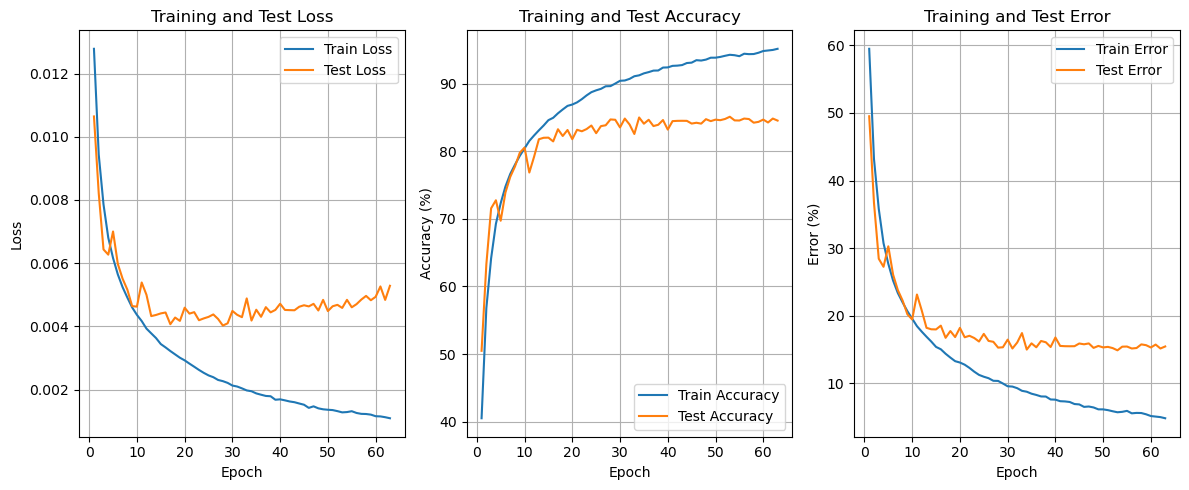

In [35]:
import numpy as np
from plot import metrics_plot

n_epochs = 100
threshold = 95
for lr in [0.134]: 
    train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = modeling(
                                                                                       n_epochs=n_epochs, 
                                                                                       lr=lr,
                                                                                       threshold=threshold)
    save_path = 'scores/E100T95'
    save_performance(save_path,
                     train_losses, test_losses, train_errs, 
                     test_errs, train_accs, test_accs, run_times, n_step=lr,
                     )
actual_nepochs = len(train_losses)
metrics_plot(actual_nepochs, train_losses, test_losses, train_accs, test_accs, train_errs, test_errs)

In [33]:
import os, json

def viz_scores(scores_path, threshold):
    contents = os.walk(scores_path)
    lr_runtime, lr_epochs, runtimes, epochs, lrs = {}, {}, [], [], []
    train_loss_dict = {}
    train_acc_dict = {}

    for root, dirs, files in contents:
        for f in files:
            if f.startswith("SGD_lr"):
                _path = os.path.join(root, f)
                with open(_path, 'r') as file:
                    data = json.load(file)
                lrs.append(data['n_step'])
                runtimes.append(sum(data['run_time']))
                epochs.append(len(data['run_time']))

                train_loss_dict[data['n_step']] = data['train_losses']
                train_acc_dict[data['n_step']] = data['train_accs']
    lr_runtime['lr'] = lrs
    lr_runtime['run_time'] = runtimes
    lr_epochs['lr'] = lrs
    lr_epochs['nepochs'] = epochs
    
    import matplotlib.pyplot as plt
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    ax1.plot(lr_runtime['lr'], lr_runtime['run_time'], label='Runtime', marker='o',linestyle='', color='blue', alpha=.5)
    ax2.plot(lr_epochs['lr'], lr_epochs['nepochs'], label='Epochs', marker='o', linestyle='', color='red', alpha=.5)

    ax1.set_ylabel('Runtime (s)')
    ax2.set_ylabel('Epochs')

    ax1.set_xlabel('Stepsize')

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')

    plt.title(f'Step size evaluation to get {threshold}% train acc')
    plt.grid(True)
    plt.show()
    return train_loss_dict, train_acc_dict

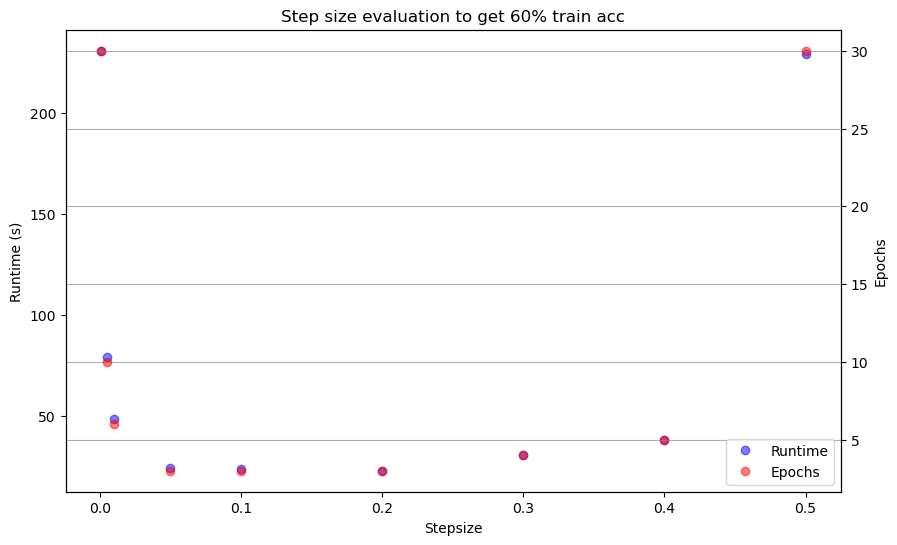

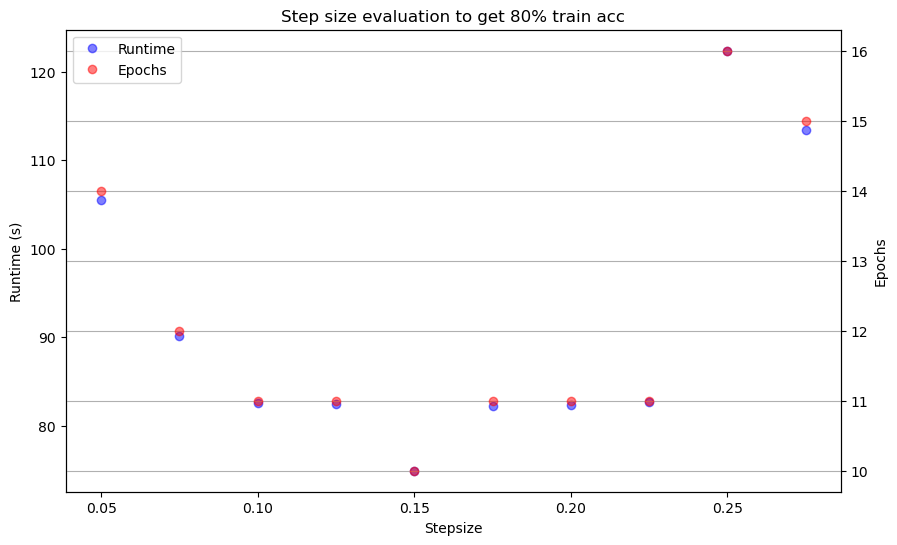

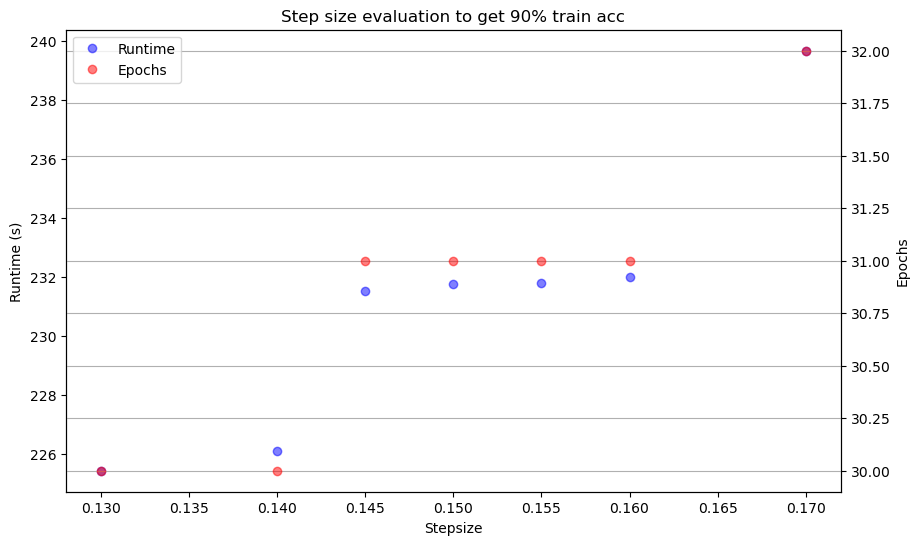

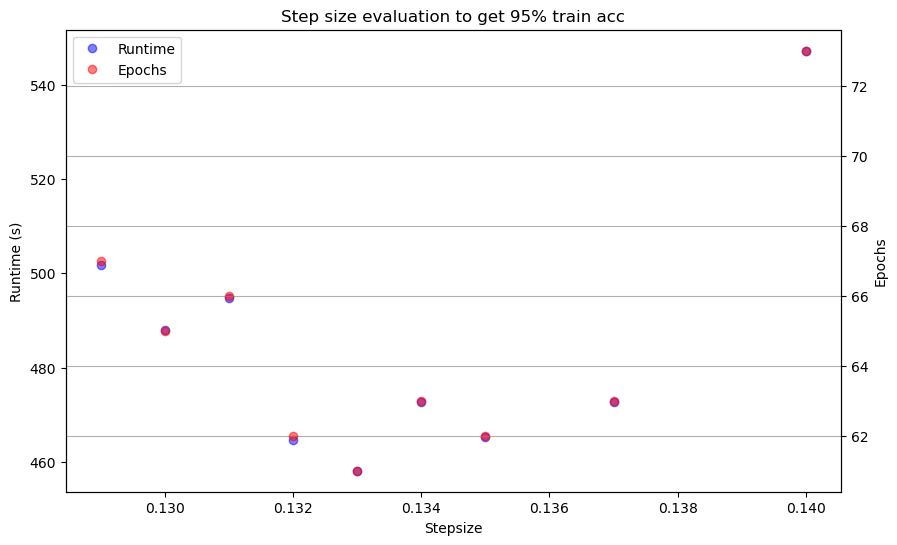

In [34]:
scores_path_1 = "scores/E30T60"
train_loss_dict_1, train_acc_dict_1 = viz_scores(scores_path_1, threshold=60)
scores_path_2 = "scores/E50T80"
train_loss_dict_2, train_acc_dict_2 = viz_scores(scores_path_2, threshold=80)
scores_path_3 = "scores/E50T90"
train_loss_dict_3, train_acc_dict_3 = viz_scores(scores_path_3, threshold=90)
scores_path_4 = "scores/E100T95"
train_loss_dict_4, train_acc_dict_4 = viz_scores(scores_path_4, threshold=95)

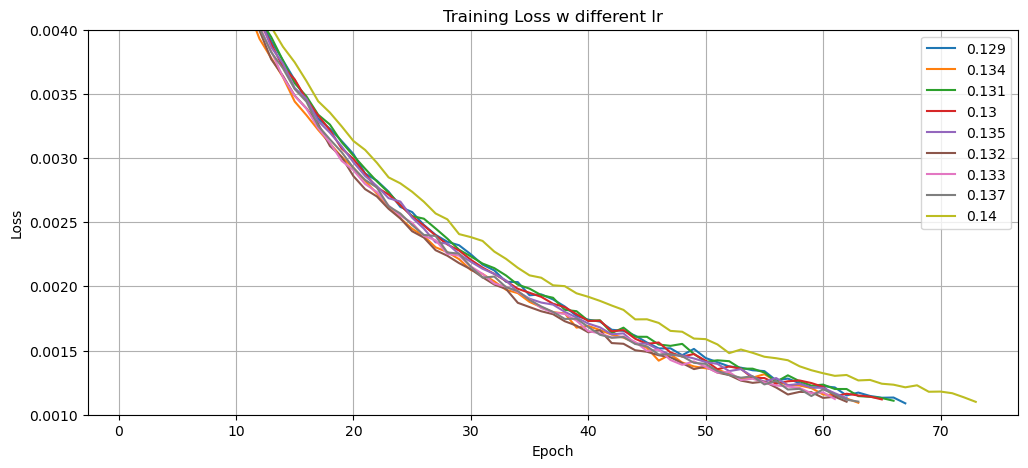

In [73]:
plt.figure(figsize=(12, 5))
for k,v in train_loss_dict_4.items():
    plt.plot(range(1, len(v)+1), v, label=k)
    
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss w different lr')
plt.ylim(0.001, 0.004)
plt.grid(True)
plt.legend()
plt.show()

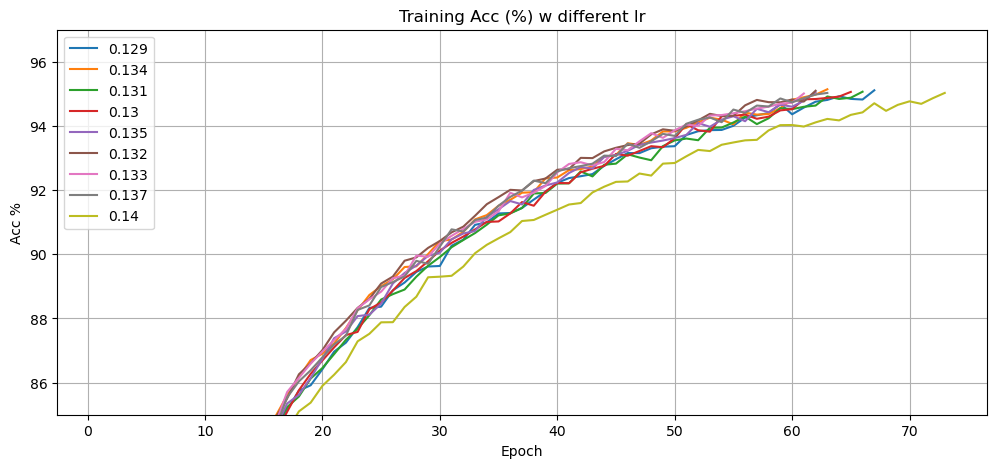

In [62]:
plt.figure(figsize=(12, 5))
for k,v in train_acc_dict_4.items():
    plt.plot(range(1, len(v)+1), v, label=k)
    
plt.xlabel('Epoch')
plt.ylabel('Acc %')
plt.ylim(85, 97)
plt.title('Training Acc (%) w different lr')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
train_loss_dict_4.keys()

dict_keys([0.129, 0.134, 0.131, 0.13, 0.135, 0.132, 0.133, 0.137, 0.14])

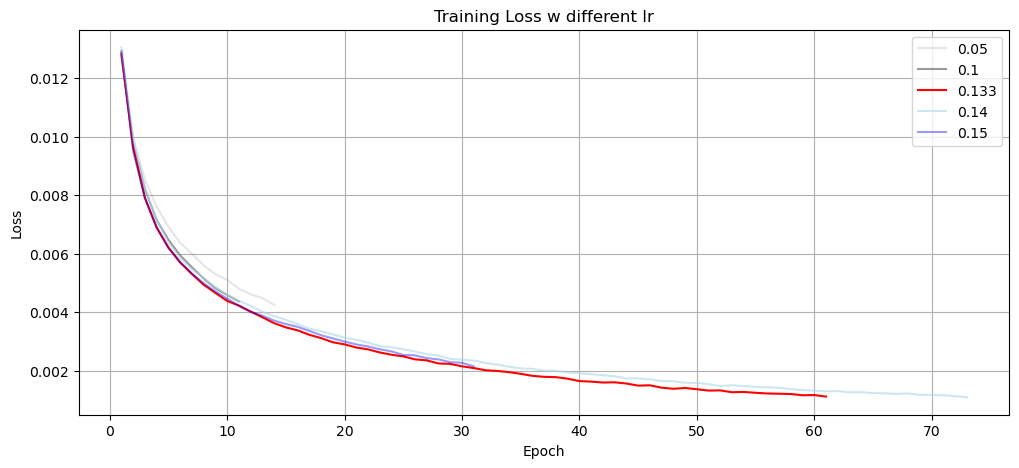

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(range(1, len(train_loss_dict_2[0.05])+1), train_loss_dict_2[0.05], label="0.05", alpha=.2, color='grey')
plt.plot(range(1, len(train_loss_dict_2[0.1])+1), train_loss_dict_2[0.1], label="0.1", alpha=.8, color='grey')
plt.plot(range(1, len(train_loss_dict_4[0.133])+1), train_loss_dict_4[0.133], label="0.133", alpha=1, color='r')
plt.plot(range(1, len(train_loss_dict_4[0.14])+1), train_loss_dict_4[0.14], label="0.14", alpha=.6, color='lightblue')
plt.plot(range(1, len(train_loss_dict_3[0.15])+1), train_loss_dict_3[0.15], label="0.15", alpha=.4, color='blue')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss w different lr')
# plt.ylim(0.001, 0.004)
plt.grid(True)
plt.legend()
plt.show()

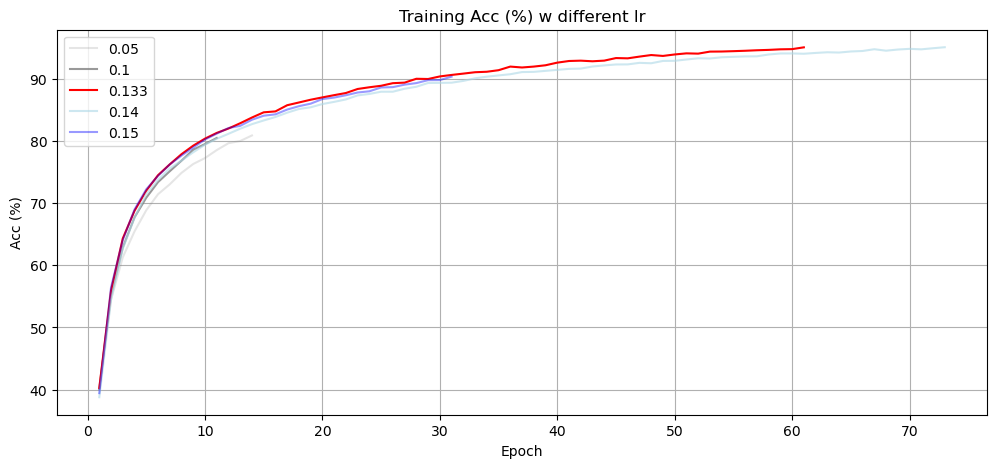

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(range(1, len(train_acc_dict_2[0.05])+1), train_acc_dict_2[0.05], label="0.05", alpha=.2, color='grey')
plt.plot(range(1, len(train_acc_dict_2[0.1])+1), train_acc_dict_2[0.1], label="0.1", alpha=.8, color='grey')
plt.plot(range(1, len(train_acc_dict_4[0.133])+1), train_acc_dict_4[0.133], label="0.133", alpha=1, color='r')
plt.plot(range(1, len(train_acc_dict_4[0.14])+1), train_acc_dict_4[0.14], label="0.14", alpha=.6, color='lightblue')
plt.plot(range(1, len(train_acc_dict_3[0.15])+1), train_acc_dict_3[0.15], label="0.15", alpha=.4, color='blue')

plt.xlabel('Epoch')
plt.ylabel('Acc (%)')
plt.title('Training Acc (%) w different lr')
# plt.ylim(0.001, 0.004)
plt.grid(True)
plt.legend()
plt.show()